# Predictive Analytics of Passenger Survival on Titanic


## 0. Sections <a id='sections'></a>

1. [Import libraries and modules](#imports)
2. [Load data](#load_data)
3. [Split data into train and test sets](#data_split)
4. [Explore data](#explore_data)
    
    4.1 [Summary of data exploration](#exploration_summary)
    
    4.2 [Required data preprocessing](#preprocessing_summary)


5. Set up data preprocessing pipeline using known data
6. Set up and combine ML pipeline with data preprocessing pipeline
7. Evaluate model performance on known data 

## 1. Import Required Libraries and Modules <a id='imports'></a>

In this section I import all the libraries and modules that are required for this project.

[Back to sections](#sections)

In [1]:
# Import libraries from Python's standard library. 
import os 
import warnings  
warnings.filterwarnings(action='ignore')
import string 
import re 

# Import third-party libraries
import IPython as ipy 
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import seaborn as sns 
import scipy as scp
import sklearn as skl 

In [2]:
#############################################################
# Print versions of imported libraries.
#############################################################
print(f'{"ipython --version":<{20}} : {ipy.__version__:s}')
print(f'{"numpy --version":<{20}} : {ipy.__version__:s}')
print(f'{"pandas --version":<{20}} : {ipy.__version__:s}')
print(f'{"matplotlib --version":<{20}} : {mpl.__version__:s}')
print(f'{"seaborn --version":<{20}} : {sns.__version__:s}')
print(f'{"scipy --version":<{20}} : {scp.__version__:s}')
print(f'{"sklearn --version":<{20}} : {skl.__version__:s}')

ipython --version    : 8.8.0
numpy --version      : 8.8.0
pandas --version     : 8.8.0
matplotlib --version : 3.6.2
seaborn --version    : 0.12.2
scipy --version      : 1.7.3
sklearn --version    : 1.2.0


In [3]:
#############################################################
# Import modules from libraries.
#############################################################
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from matplotlib import pyplot as plt 

from scipy.stats import mode

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing as sklpp
from sklearn import metrics as sklm

## 2. Load Dataset <a id='load_data'></a>

Herein, I load the Titanic dataset as a Pandas DataFrame and display it to make certain that data import is successful. 

[Back to sections](#sections)

In [30]:
data_location = "./dataset/titanic.csv"
orig_data = pd.read_csv(filepath_or_buffer=data_location, header='infer', na_values='?')

In [31]:
print('Original (complete) dataset:')
display(orig_data)

Original (complete) dataset:


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S
...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,NaN,C
1305,3,0,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,NaN,C
1307,3,0,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,NaN,C


## 3. Split data into train and test sets <a id='data_split'></a>

In this section I split (i.e., partition) the Titanic data set into two partitions, namely, train set and a test set. The machine learning model will be trained on the train set while it will be tested (for performance)  on the test set. In the subsequent sections, the train set will be utilized for creating and standardizing a machine learning pipeline that will be later applied on the test set. The machine learning pipeline will consists of data preprocessing steps and model training and validation steps. Note that, the test data will not be touched except in the last section of this notebook.

[Back to sections](#sections)

In [23]:
#############################################################
# Define random seed for reproducibility of results.
#############################################################
seed = 42
np.random.seed(seed)

test_data = orig_data.sample(frac=0.15)
test_indices = test_data.index
test_data = test_data.reset_index().drop(columns=['index', ], axis=1)

print('Num. rows & columns in test dataset: %d, %d' %(test_data.shape[0], test_data.shape[1]))
print()
print('Print test dataset:')
display(test_data)

Num. rows & columns in test dataset: 196, 14

Print test dataset:


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,3,0,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,NaN,NaN,NaN
1,3,1,"Nakid, Mr. Sahid",male,20.0,1,1,2653,15.7417,NaN,C,C,NaN,NaN
2,3,0,"Lyntakoff, Mr. Stanko",male,NaN,0,0,349235,7.8958,NaN,S,NaN,NaN,NaN
3,3,0,"Ford, Mr. Arthur",male,NaN,0,0,A/5 1478,8.0500,NaN,S,NaN,NaN,"Bridgwater, Somerset, England"
4,3,0,"Shaughnessy, Mr. Patrick",male,NaN,0,0,370374,7.7500,NaN,Q,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,3,0,"Skoog, Master. Harald",male,4.0,3,2,347088,27.9000,NaN,S,NaN,NaN,NaN
192,3,0,"Olsen, Mr. Henry Margido",male,28.0,0,0,C 4001,22.5250,NaN,S,NaN,173.0,NaN
193,2,1,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,14,NaN,"Harrow, England"
194,3,0,"Betros, Master. Seman",male,NaN,0,0,2622,7.2292,NaN,C,NaN,NaN,NaN


In [24]:
train_data = orig_data.loc[~orig_data.index.isin(test_indices), :]

print('Num. rows & columns in train dataset: %d, %d' %(train_data.shape[0], train_data.shape[1]))
print()
print('Train dataset:')
display(train_data)

Num. rows & columns in train dataset: 1113, 14

Train dataset:


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3,0,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3,0,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN


From now onwards, we will be working with the known/seen (`known_data`) data set and reserve the holdout/unknown (`unknown_data`) data set for evaluating model performance *only*. 

## 4. Explore data <a id='explore_data'></a>

In this section I will explore the data (train data to be specific) from all plausible angles and then, make a summary of these explorations that will help me decide the preprocessing steps that are required for the Titanic dataset.

[Back to sections](#sections)

In [25]:
print(f'Train data has {train_data.shape[0]:d} rows and {train_data.shape[1]:d} columns')
print()

print('Display train dataset:')
display(train_data)
print()

Train data has 1113 rows and 14 columns

Display train dataset:


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3,0,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3,0,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN


In [26]:
print('Information (meta-data) about train data:')
train_data.info(memory_usage='deep')
print()

Information (meta-data) about train data:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1113 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1113 non-null   int64  
 1   survived   1113 non-null   int64  
 2   name       1113 non-null   object 
 3   sex        1113 non-null   object 
 4   age        895 non-null    float64
 5   sibsp      1113 non-null   int64  
 6   parch      1113 non-null   int64  
 7   ticket     1113 non-null   object 
 8   fare       1112 non-null   float64
 9   cabin      249 non-null    object 
 10  embarked   1111 non-null   object 
 11  boat       400 non-null    object 
 12  body       105 non-null    float64
 13  home.dest  639 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 509.6 KB



In [27]:
print('Information about null/missing values in train dataset:')

missing_df = pd.DataFrame(train_data.isna().sum(), columns=['Num_Nulls'])
missing_df['Pct_Nulls'] = round( ((missing_df / train_data.shape[0]) * 100), ndigits=2) 
display(missing_df)
print()

Information about null/missing values in train dataset:


,Num_Nulls,Pct_Nulls
pclass,0,0.00
survived,0,0.00
name,0,0.00
sex,0,0.00
age,218,19.59
sibsp,0,0.00
parch,0,0.00
ticket,0,0.00
fare,1,0.09
cabin,864,77.63


In [28]:
cols_list = train_data.columns.to_list()

print('Print column names:')
print(*cols_list, sep='\n')
print()

Print column names:
pclass
survived
name
sex
age
sibsp
parch
ticket
fare
cabin
embarked
boat
body
home.dest



In [34]:
train_data['parch'].value_counts()

0    847
1    145
2     98
3      8
5      6
4      5
6      2
9      2
Name: parch, dtype: int64

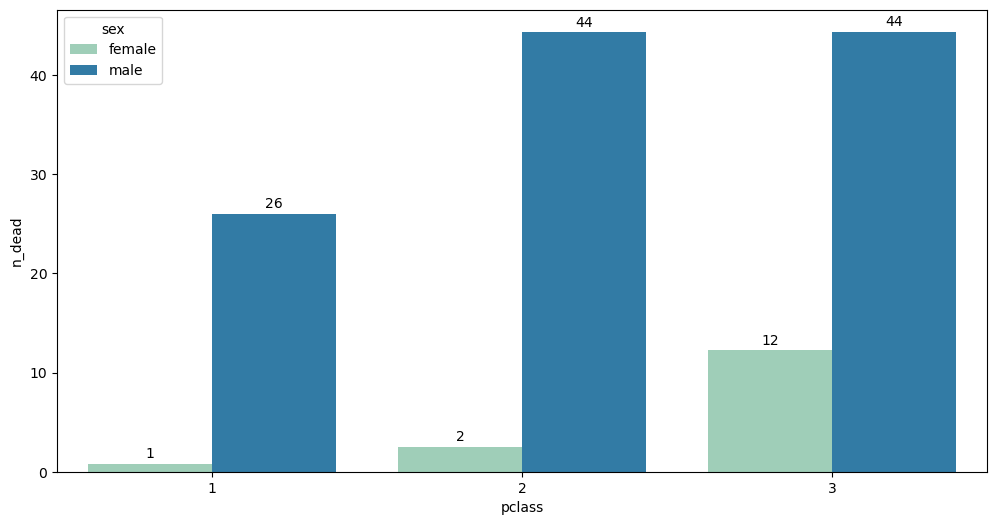

In [91]:
groupby_df = train_data.groupby(by=['sex', 'pclass', 'parch'], as_index=False).agg(
    n_survivors=('survived', 'sum'), 
    n_passengers=('survived', 'count'),)
groupby_df['n_dead'] = groupby_df['n_passengers'] - groupby_df['n_survivors']

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.barplot(data=groupby_df, x='pclass', y='n_dead', hue='sex', ci=0.0, palette='YlGnBu', ax=ax)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 7), textcoords='offset points')
plt.show();

In [132]:
groupby_df =pd.crosstab(
    index=train_data['embarked'],
    columns=train_data['sex'],
    values=train_data['survived'],
    aggfunc=lambda x: x.sum(),
    rownames=['n_parch',],
    colnames=['gender'],
    margins=True,
    margins_name='Total',
)
groupby_df

gender,female,male,Total
n_parch,,,
C,81,39,120
Q,29,6,35
S,166,86,252
Total,276,131,407


In [120]:
groupby_df =pd.crosstab(
    index=train_data['sex'],
    columns=train_data['sibsp'],
    rownames=['Gender',],
    colnames=['n_sibsp'],
    margins=True,
    margins_name='Total',
)
groupby_df

n_sibsp,0,1,2,3,4,5,8,Total
Gender,,,,,,,,
female,212,137,18,11,6,2,4,390
male,531,145,19,7,13,4,4,723
Total,743,282,37,18,19,6,8,1113


In [95]:
groupby_df = train_data.groupby(by=['parch', 'sibsp',], as_index=False).agg(
    n_parents=('survived', 'sum'), 
    n_passengers=('survived', 'count'),)
groupby_df
# groupby_df['n_dead'] = groupby_df['n_passengers'] - groupby_df['n_survivors']

# fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# sns.barplot(data=groupby_df, x='pclass', y='n_dead', hue='sex', ci=0.0, palette='YlGnBu', ax=ax)
# for p in ax.patches:
#     ax.annotate(format(p.get_height(), '.0f'), 
#                 (p.get_x() + p.get_width() / 2., p.get_height()), 
#                 ha='center', va='center', 
#                 xytext=(0, 7), textcoords='offset points')
# plt.show();

,parch,sibsp,n_parents,n_passengers
0,0,0,185,655
1,0,1,77,167
2,0,2,6,22
3,0,3,2,3
4,1,0,33,45
5,1,1,41,74
6,1,2,8,8
7,1,3,1,9
8,1,4,0,9
9,2,0,26,37


### 4.1 Summary of data exploration <a id='exploration_summary'></a>

1. There are 1113 rows and 14 columns (13 predictor variables and 1 response variable). 


2. Data types of these 14 columns are as follows:
    - 3 columns with floating-point (real) values.
    - 4 columns with integer values.
    - 7 columns with object (string/textual) values.
    
    
3. The following columns have null values - **NOTE:** The target (response) variable has no missing values.

| S. N | Variable | # Missing Values | Pct. missing values |
| :---: | :---: | :---: | :---: |
| 1. | **age** | 218 | 19.59 |
| 2. | **fare** | 1 | 0.09 |
| 3. | **cabin** | 864 | 77.63 |
| 4. | **embarked** | 2 | 0.18 |
| 5. | **boat** | 713 | 64.06 |
| 6. | **body** | 1008 | 90.57 |
| 7. | **home.dest** | 474 | 42.59 |


4. The descriptions of the last three columns, namely, `boat`, `body`, and `home.dest`, are not clearly mentioned in the data dictionary. Furthermore, quick examinations of these variables show that they will not add any significant information to the machine learning model.   

### 4.2 Required data preprocessing <a id="preprocessing_summary"></a>

In [12]:
def extract_title(input_df):
    input_df['title'] = input_df['name'].apply(lambda x: x.split(' ')[1])
    input_df['title'] = input_df['title'].str.replace(r"\S$", "", regex=True)
    return input_df

In [13]:
extract_title_ct = sklpp.FunctionTransformer(extract_title)

In [14]:
cts = ColumnTransformer(
    transformers=[
        ('drop_columns', 'drop', ['boat', 'body', 'home.dest']),
        ('extract title', extract_title_ct, ['name',]),
    ],
    remainder='passthrough',
    verbose=True, 
    n_jobs=-1
)

In [16]:
cts.set_output(transform='pandas')
train_data = cts.fit_transform(train_data)

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('drop_columns', 'drop',
                                 ['boat', 'body', 'home.dest']),
                                ('extract title',
                                 FunctionTransformer(func=<function extract_title at 0x7fe3d5a6d940>),
                                 ['name'])],
                  verbose=True)

In [17]:
train_data

,extract title__name,extract title__title,remainder__pclass,remainder__survived,remainder__sex,remainder__age,remainder__sibsp,remainder__parch,remainder__ticket,remainder__fare,remainder__cabin,remainder__embarked
0,"Allen, Miss. Elisabeth Walton",Miss,1,1,female,29.0000,0,0,24160,211.3375,B5,S
1,"Allison, Master. Hudson Trevor",Master,1,1,male,0.9167,1,2,113781,151.5500,C22 C26,S
2,"Allison, Miss. Helen Loraine",Miss,1,0,female,2.0000,1,2,113781,151.5500,C22 C26,S
3,"Allison, Mr. Hudson Joshua Creighton",Mr,1,0,male,30.0000,1,2,113781,151.5500,C22 C26,S
4,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",Mrs,1,0,female,25.0000,1,2,113781,151.5500,C22 C26,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,"Zabour, Miss. Hileni",Miss,3,0,female,14.5000,1,0,2665,14.4542,NaN,C
1305,"Zabour, Miss. Thamine",Miss,3,0,female,NaN,1,0,2665,14.4542,NaN,C
1306,"Zakarian, Mr. Mapriededer",Mr,3,0,male,26.5000,0,0,2656,7.2250,NaN,C
1307,"Zakarian, Mr. Ortin",Mr,3,0,male,27.0000,0,0,2670,7.2250,NaN,C


We will remove any column that has percentage of missing (null) values greater than or equal to $90\%$.

Below, the distribution of unique values in all columns is provided.  

In [ ]:
print('Variable distributions:')
for col in cols_list:
    print(f'Variable: {col:<{12}} --- Distribution:\n{known_data[col].value_counts()}')
    print()

## 5. Set up data preprocessing pipeline using known data